In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
import os
import requests
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

torch.Size([3, 1280, 852])
torch.Size([1280, 852])


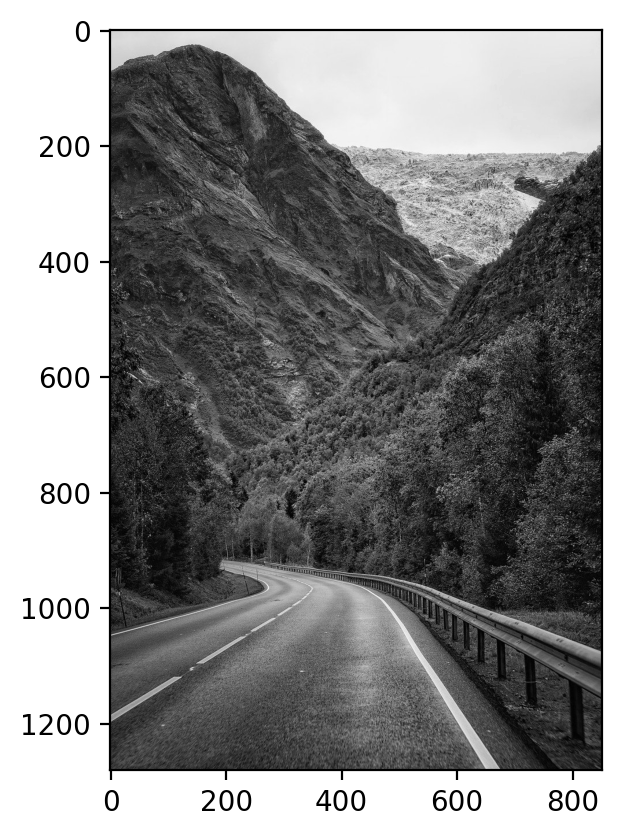

In [14]:
# if os.path.exists('dog.jpg'):
#     print('dog.jpg exists')
# else:
#     url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open('dog.jpg', 'wb') as file:
#             file.write(response.content)
#         print('dog.jpg downloaded successfully')
#     else:
#         print('Failed to download dog.jpg')

img = torchvision.io.read_image('road-8284023_1280.jpg')
print(img.shape)
img = img.clone().detach().float()
# print(img.shape)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

plt.imshow(img, cmap='gray')

torch.Size([300, 300])


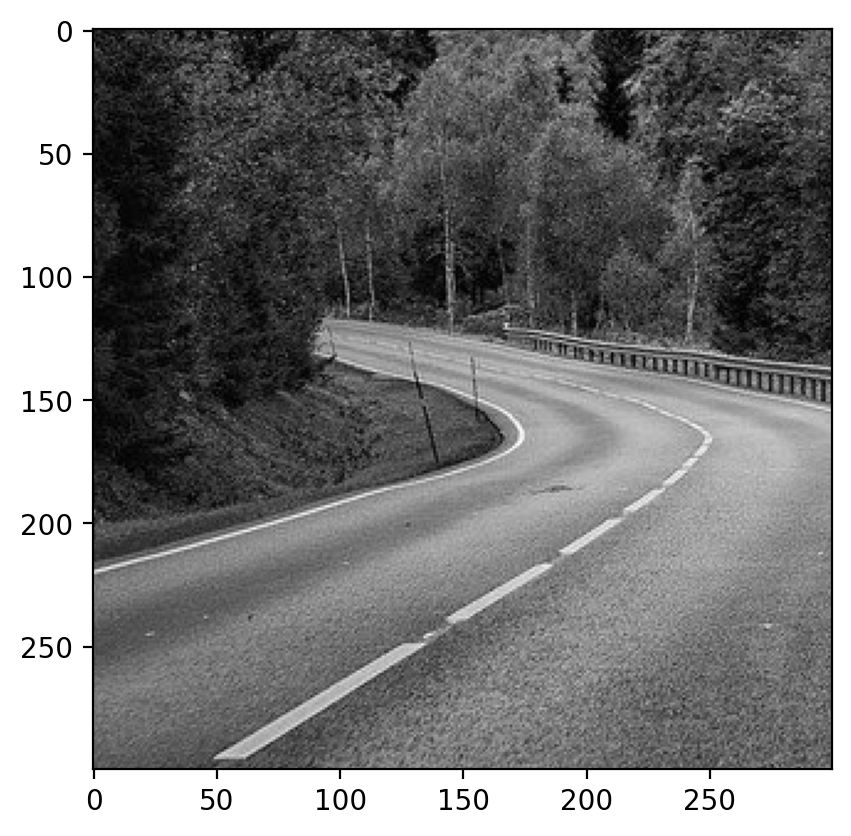

In [15]:
crop = torchvision.transforms.functional.crop(img, 800, 100, 300, 300)
print(crop.shape)
plt.imshow(crop, cmap='gray')

tensor(26885)


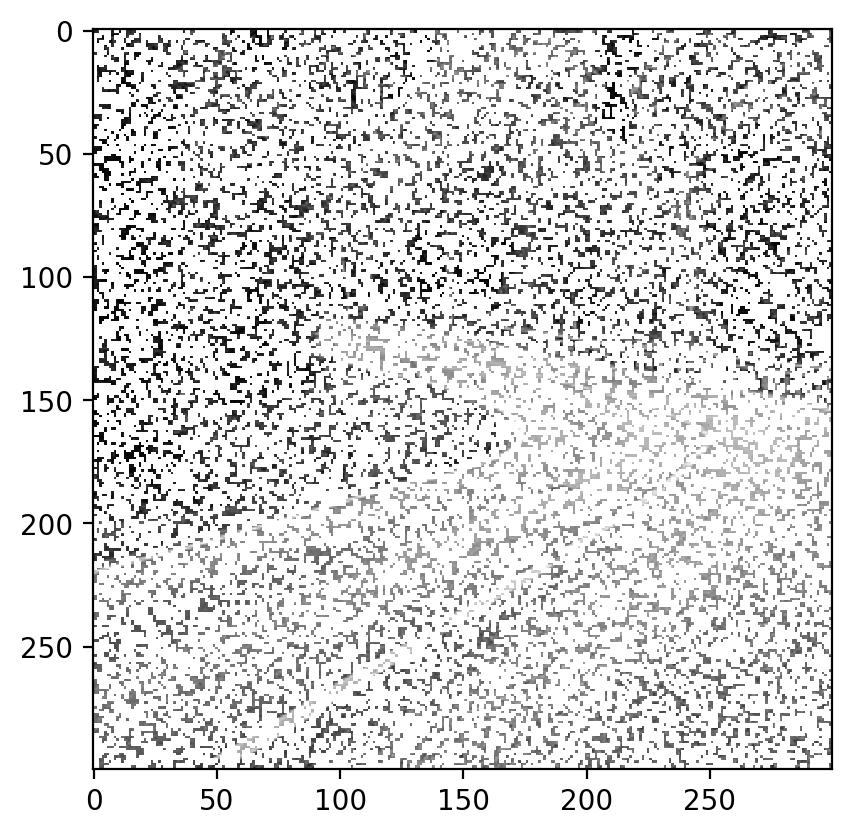

In [16]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

masked_image, mask = mask_image(crop, 0.3)
print(mask.sum())
plt.imshow(masked_image, cmap='gray')

In [33]:
# def factorize(A, k, device=torch.device("cpu")):
#     """Factorize the matrix A into W and H
#     A: input matrix of size (n_users, n_movies)
#     k: number of latent features

#     Returns W and H
#     W: matrix of size (n_users, k)
#     H: matrix of size (k, n_movies)
#     """
#     A = A.to(device)
#     # Randomly initialize W and H
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)

#     # Train the model
#     for i in range(1000):
#         # Compute the loss
#         loss = torch.norm(torch.mm(W, H) - A)

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Backpropagate
#         loss.backward()

#         # Update the parameters
#         optimizer.step()

#     return W, H, loss

def factorize(A, k, device=torch.device("cpu"), epsilon = 0.001):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    epoch = 0
    # Train the model
    while True:
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        epoch += 1
        if epoch>1:
            if prev_loss-loss < epsilon:
                break
        # if epoch>=100 and epoch%100==0:
        #     print(f'Epoch:{epoch}--->Loss:{loss}, prev_loss:{prev_loss}')
        prev_loss = loss

    # print(f'No of Epochs:{epoch}')

    return W, H, loss

def reconstruct_img(masked_image,factors=50,device=torch.device("cpu")):#returns torch
    W, H, _ = factorize(masked_image,factors,device)
    reconstruct_img = torch.mm(W, H).cpu().detach()
    return reconstruct_img




In [18]:
W, H, loss = factorize(masked_image, 50, device=device) 
print(loss)

tensor(3041.1589, grad_fn=<LinalgVectorNormBackward0>)

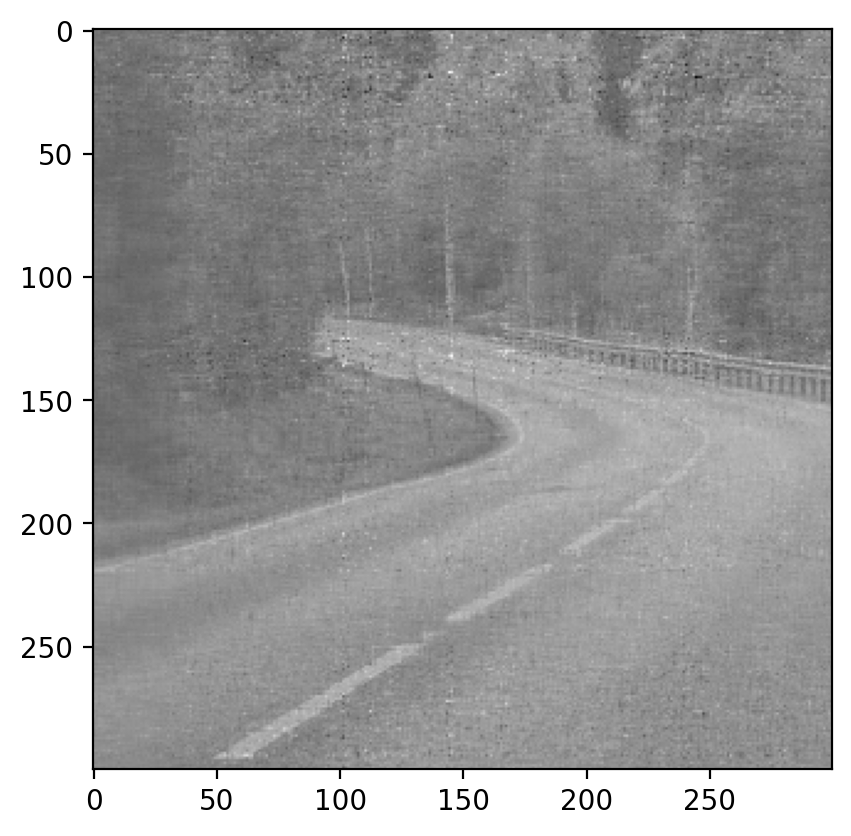

In [19]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

In [26]:
def compute_rmse(tensor1, tensor2):
    # Ensure both tensors are on the same device (GPU)
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()


def plot_image_completion(prop=0.1, factors=50):
    masked_image, mask = mask_image(crop, prop)
    reconstructed_img = reconstruct_img(masked_image, factors)
    print(f'For Reconstructed and Original Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img,crop)} and PSNR:{compute_psnr(reconstructed_img,crop)}')
    print(f'For Reconstructed and Masked Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img[~mask],masked_image[~mask])} and PSNR:{compute_psnr(reconstructed_img[~mask],masked_image[~mask])}')
    reconstructed_img = reconstructed_img.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(masked_image, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(crop, cmap="gray")
    ax[1].set_title("Original image")
    ax[2].imshow(reconstructed_img, cmap='gray')
    ax[2].set_title("Reconstructed image")
    fig.suptitle(f'prop:{prop}, factors:{factors}')
    plt.show()

For Reconstructed and Original Images with prop:0.1, factors:50
RMSE:15.639326095581055 and PSNR:-23.884361267089844
For Reconstructed and Masked Images with prop:0.1, factors:50
RMSE:13.99339485168457 and PSNR:-22.9184627532959


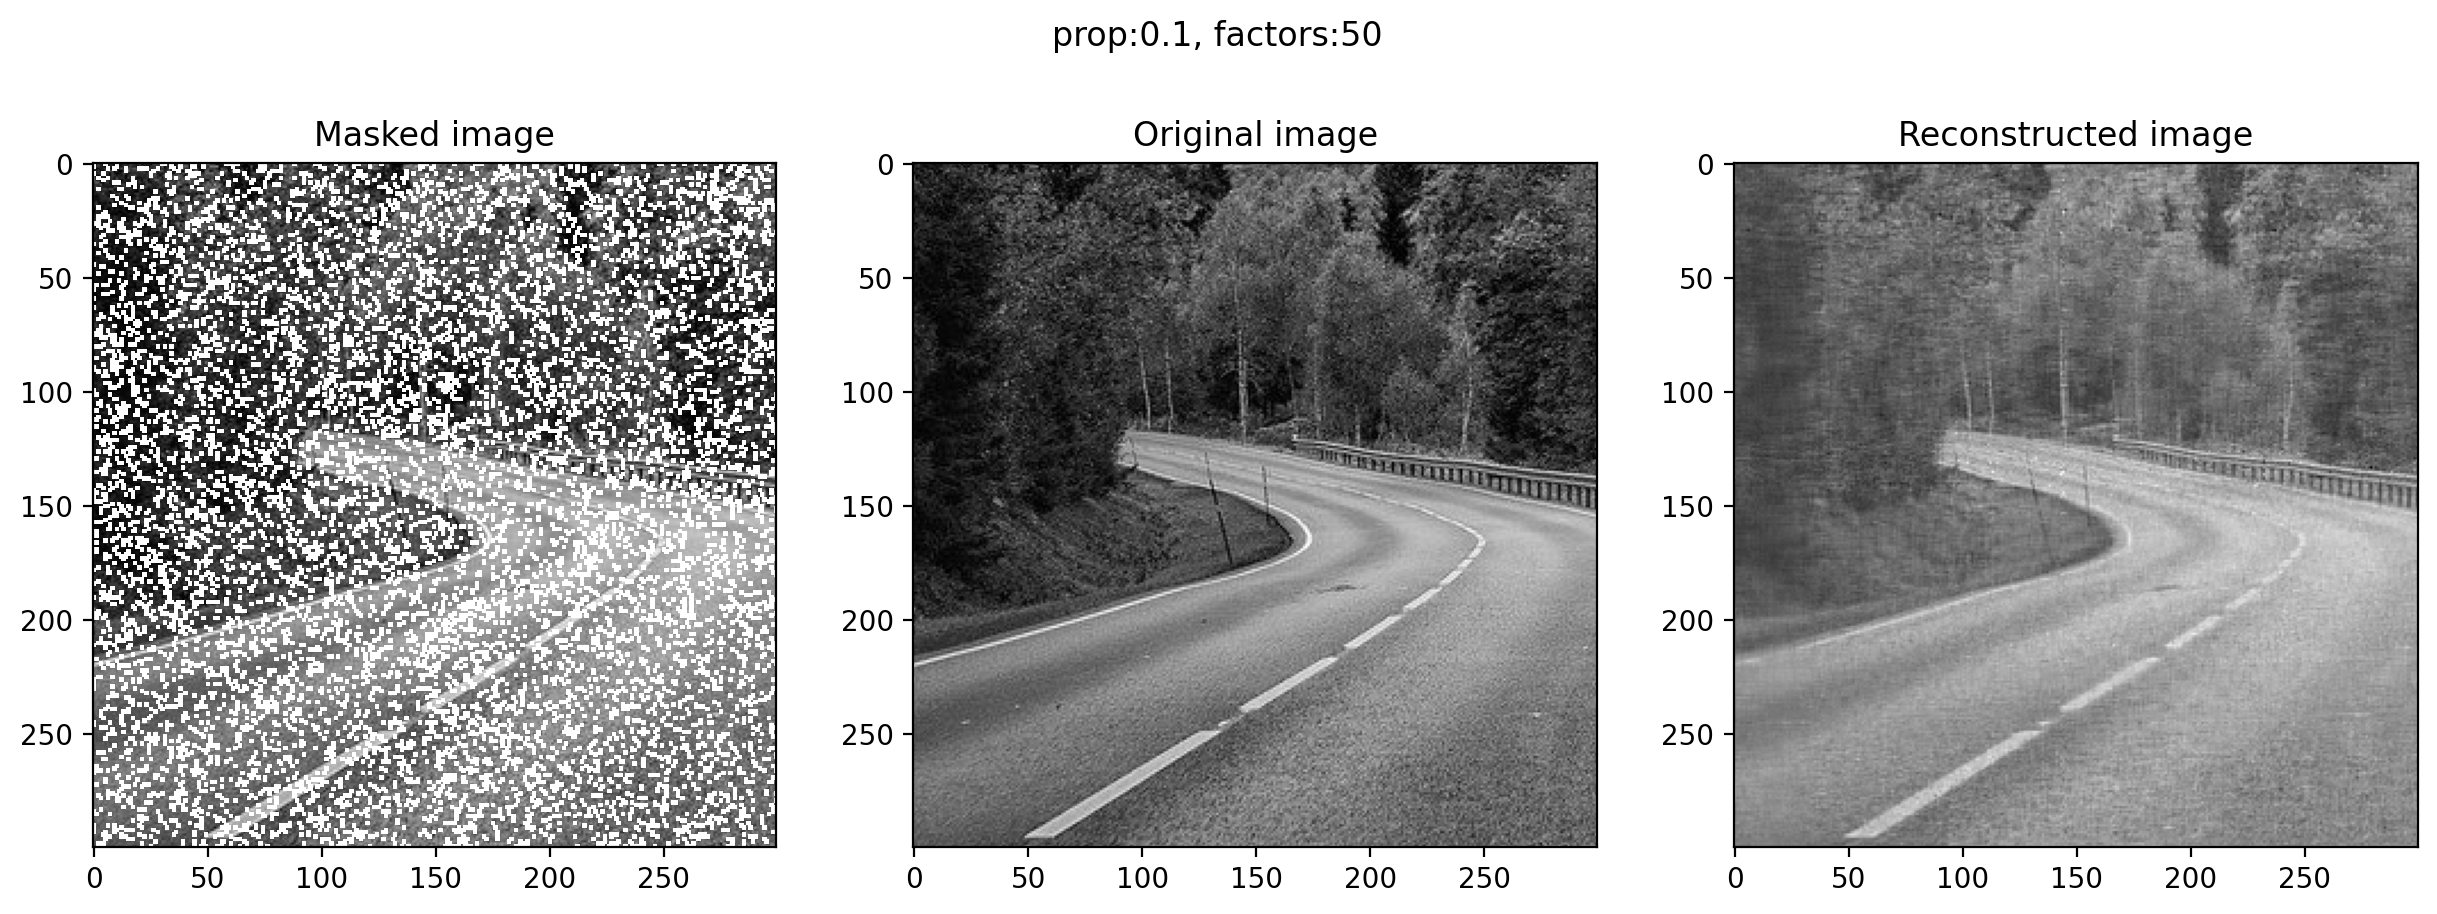

In [27]:
plot_image_completion()
# prop_i = [0.1,0.3,0.5,0.7,0.9]
# factors_i = [5,10,25,50]
# for i in prop_i:
#     for j in factors_i:
#         plot_image_completion(prop=i,factors=j)



task-4 part-2

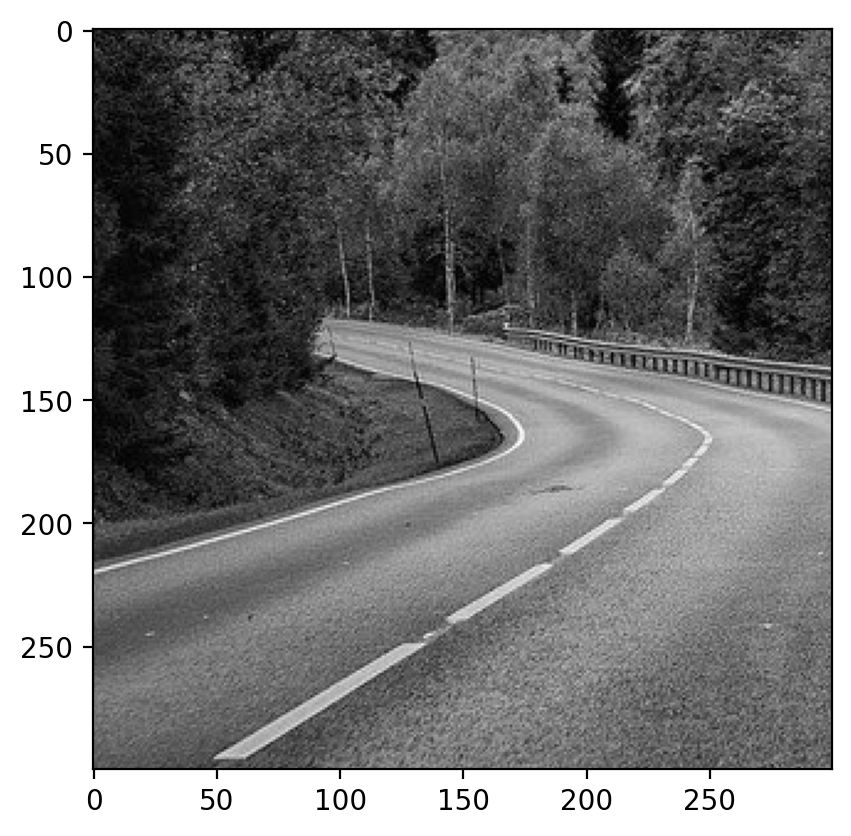

In [28]:
crop2 = torchvision.transforms.functional.crop(img, 800, 100, 300, 300)
plt.imshow(crop2, cmap="gray")


torch.Size([30, 30])


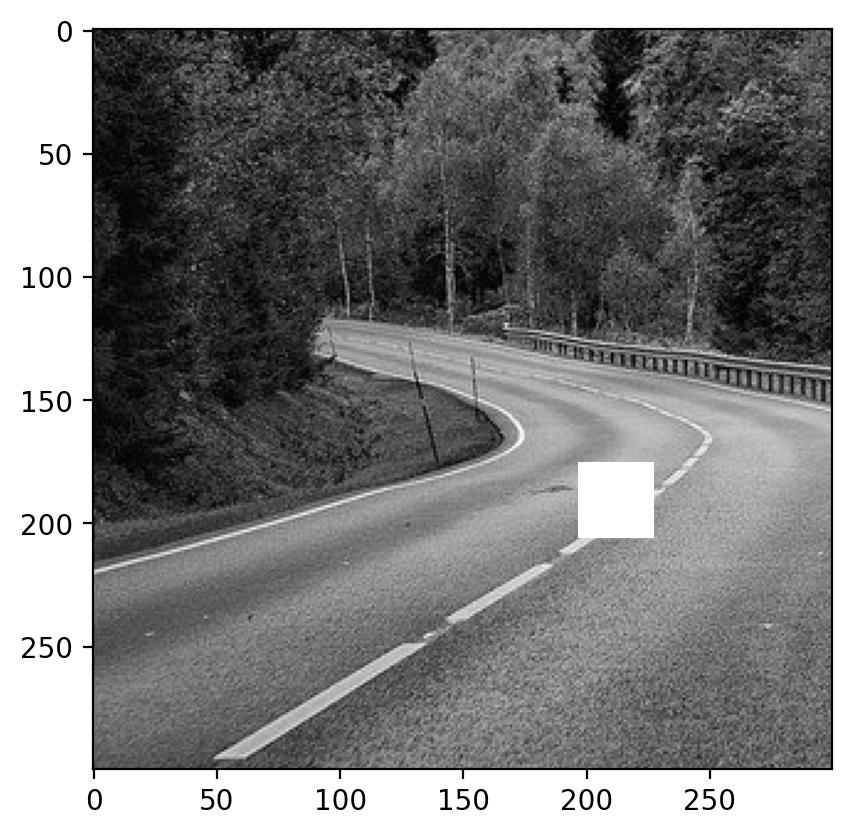

In [32]:
def mask_900_pixel(img):
    img = img.clone()
    np.random.seed(50)
    a = np.random.randint(0,269)
    np.random.seed(78)
    b = np.random.randint(0,269)
    mask = np.zeros((30,30))
    mask[mask==0] = float('nan')
    mask = torch.from_numpy(mask)
    print(mask.shape)
    img[a:a+30,b:b+30] = mask

    return img

mask_900_img = mask_900_pixel(crop)
plt.imshow(mask_900_img,cmap='gray')

In [35]:
# def plot_image_completion(masked_image,crop, factors=50):
#     mask = masked_image.isnan()
#     reconstructed_img = reconstruct_img(masked_image, factors)
#     # print(f'For Reconstructed and Original Images with prop:{prop}, factors:{factors}')
#     # print(f'RMSE:{compute_rmse(reconstructed_img,crop)} and PSNR:{compute_psnr(reconstructed_img,crop)}')
#     # print(f'For Reconstructed and Masked Images with prop:{prop}, factors:{factors}')
#     # print(f'RMSE:{compute_rmse(reconstructed_img[~mask],masked_image[~mask])} and PSNR:{compute_psnr(reconstructed_img[~mask],masked_image[~mask])}')
#     reconstructed_img = reconstructed_img.numpy()
#     fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#     ax[0].imshow(masked_image, cmap='gray')
#     ax[0].set_title("Masked image")
#     ax[1].imshow(crop, cmap="gray")
#     ax[1].set_title("Original image")
#     ax[2].imshow(reconstructed_img, cmap='gray')
#     ax[2].set_title("Reconstructed image")
#     # fig.suptitle(f'factors:{factors}')
#     plt.show()

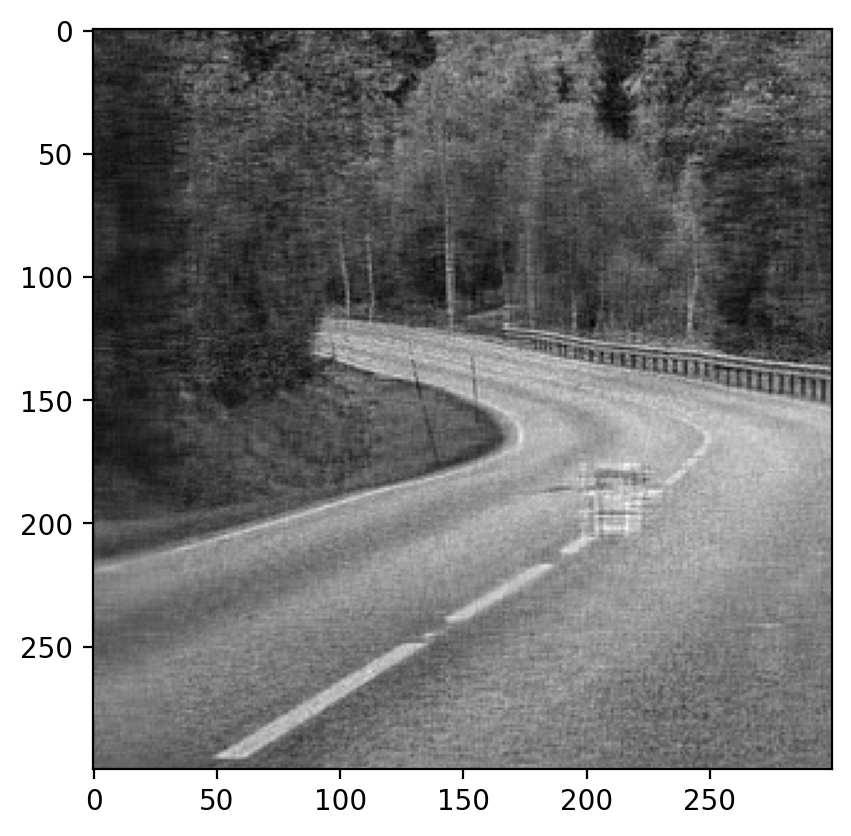

In [39]:
mf_reconstructed_900_img = reconstruct_img(mask_900_img)
plt.imshow(mf_reconstructed_900_img, cmap='gray')

Text(0.5, 1.0, 'Reconstructed image')

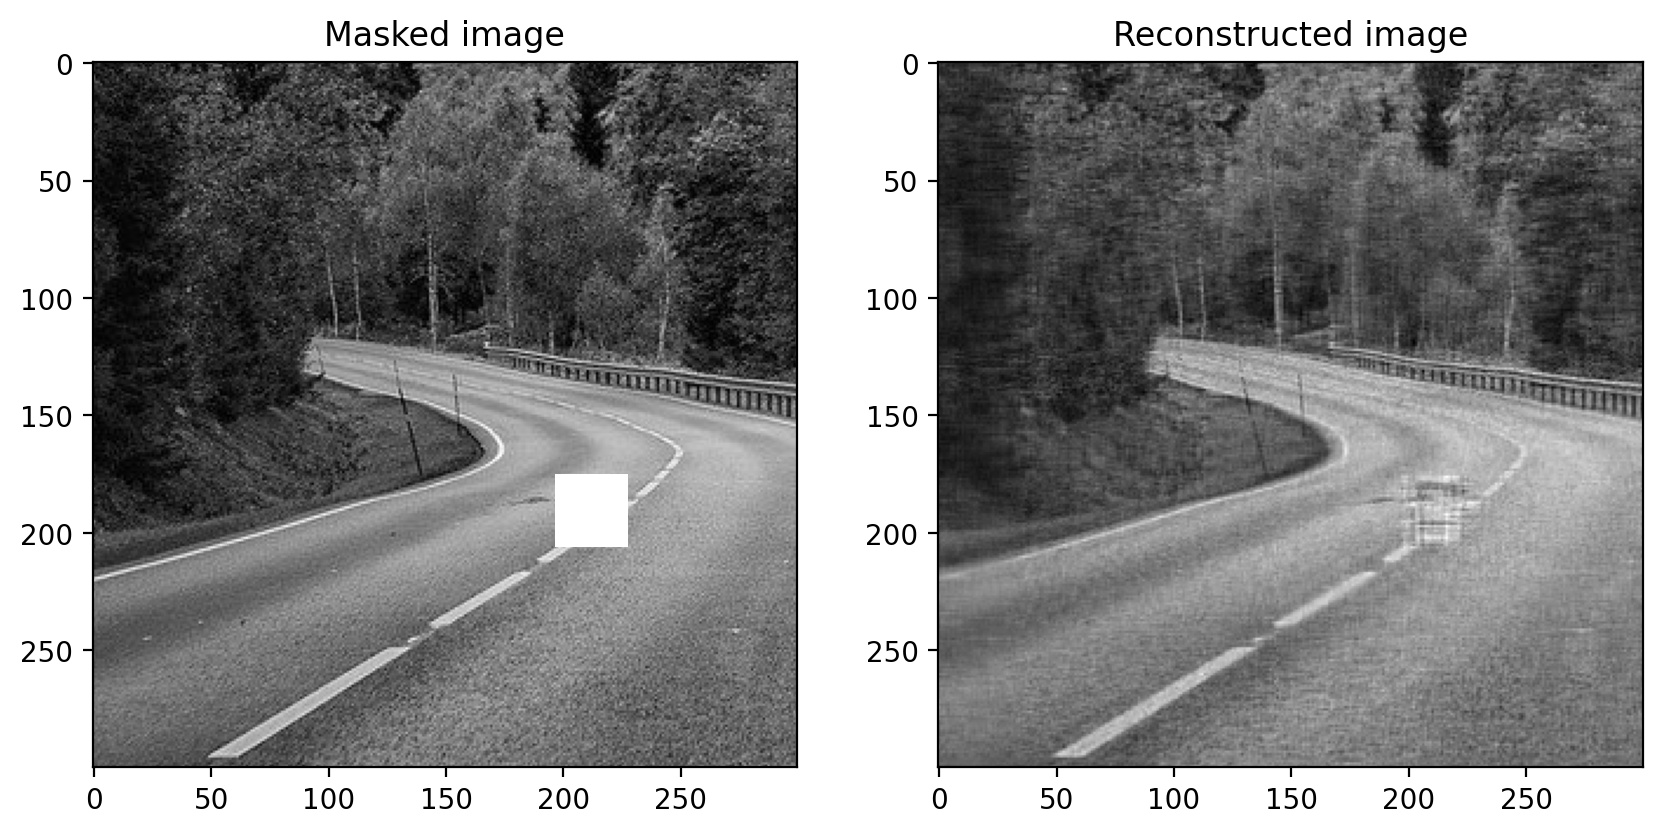

In [40]:
ig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_900_img, cmap='gray')
ax[0].set_title("Masked image")
ax[1].imshow(mf_reconstructed_900_img, cmap="gray")
ax[1].set_title("Reconstructed image")